# ML Art challenge

This challenge is aimed on creation of AI that capable to determine a genre of an artwork based on its visual appearance. Visual appearance of an artwork is represented by photos that are carefully distributed into categories.

**Data**

The data given in the competition is supposed to have an hierarchical structure. There are 6 top level categories:
* Architecture
* Graphics
* Installations
* Sculptures
* Paintings
* Decorativa and Applied Art

Each of these top-level categories variable amount of sub-categories. For example, Paintings category contains 10 genres which are titled as Battle, Animalistic, Abstract, and etc. 

Practically however, images are flat-labeled into 40 classes.

**Working schedule:**

- EDA;
- data preprocessing;
- training the models;
- evaluation (with macro averaged F1 as KPI).

**Goals:**

Building a model that's capable of classifying an artwork genre based on its visual appearance. Macro averaged F1 measure on the test set should exceed 0.94.

**Units required:**

- Pandas
- PyTorch
- skorch
- timm
- scikit-learn
- PIL
- NumPy
- Matplotlib
- Seaborn

## Data review

In [1]:
#!pip install skorch --user

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, WeightedRandomSampler, random_split

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import ProgressBar, Checkpoint, LRScheduler, EpochScoring

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import pandas as pd
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import seaborn as sns

from PIL import Image
from multiprocessing import Pool
from pathlib import Path

from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, make_scorer, classification_report, recall_score, precision_score

import random
from scipy.spatial.distance import cityblock
from sklearn.datasets import make_classification

In [3]:
import warnings
warnings.simplefilter(action='ignore')

In [4]:
RANDOM_STATE = 177013
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.benchmark = True

In [5]:
TRAIN_DIR = 'storage/datasets/art/train'
TEST_DIR = 'storage/datasets/art/test'
BATCH_SIZE = 16
NUM_WORKERS = 12
RESCALE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
df = pd.read_csv('storage/datasets/art/train.csv', sep='\t')

In [7]:
df.head()

image_name  label_id
0  2517faa709464b11b50320c3df14f73e.jpg         0
1  eaa6183e2e564825bf1722bb81eba5e8.jpg         0
2  b4d6139ce7284bf3acc0efff921a9605.jpg         0
3  e5171990747448959d68a7d552a93857.jpg         0
4  0eda4b64670a446c9bfd9d70a4c72e01.jpg         0

### Class ratio

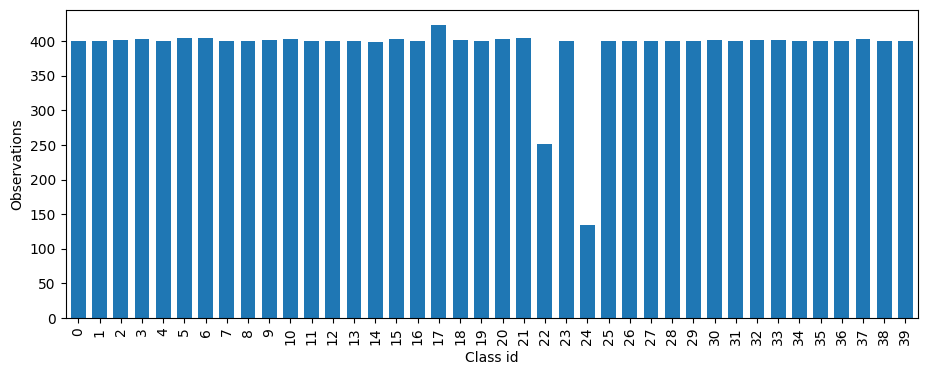

In [8]:
df['label_id'].value_counts().sort_index().plot(kind='bar', figsize=(11,4), width=0.7).set(xlabel='Class id', ylabel='Observations');

Apart from classes 22 and 24 which lack samples somewhat, most of the genres are almost euqally represented. Model should have no trouble generalizing.

In [9]:
# pandas lookup is often not so fast, so we shall convert targets to a dict:
labels = dict(df.values)

In [10]:
# TODO: explore and assign names to classes
nice_label = lambda n: str(n.item() if torch.is_tensor(n) else n)

In [11]:
def decode(codes):
    distances = [[cityblock(dataset.code_book[i], codes[j]) for i in range(40)] for j in range(len(codes))]
    return np.argmin(distances, axis=1)

### Data augmentation

The following augmentations will be used:
- slight random shift and rotation;
- random horizontal flip;
- random blur, distortion or gaussian noise;
- additional sharpen/emboss/etc.

Transformations also include:
- resizing to 224х224 (LongestMaxSize + PadIfNeeded);
- normalizing by standard ImageNet values.

In [12]:
# Train/validation transformations:
transform = A.Compose([
        A.LongestMaxSize(RESCALE_SIZE),
        A.PadIfNeeded(RESCALE_SIZE, RESCALE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=3, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize(),
        ToTensorV2(),
    ])

# Inference transformations:
inference_transform = A.Compose(
    [
        A.LongestMaxSize(RESCALE_SIZE),
        A.PadIfNeeded(RESCALE_SIZE, RESCALE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)

### Dataset implementation

We'll be encoding classes as Hamming codes with 2x the number of classes size:

In [13]:
NUM_CLASSES=40
CODE_SIZE = 80

In [14]:
class ArtDataset(torch.utils.data.Dataset):
    @staticmethod
    def process_dir(path):
        '''
        Extracts the observation id from filename.
        '''
        return path.name
    
    def __init__(self, folder, labels, augment=False):
        '''
        Accepts the folder and labels dict, and whether to use augmentations.
        '''
        self.root = folder
        self.labels = labels
        self.files = []
        self.augment = augment
        # build a list of files:
        pool = Pool(12)
        root_path = Path(folder)
        top = [dir for dir in filter(Path.is_file, root_path.iterdir())]
        results = pool.map(ArtDataset.process_dir, top)
        if results:
            self.files.extend(results)
        self.file = np.array(self.files)
        rng = random.Random(177013)
        #self.code_book = np.array([list(f"{code:b}".zfill(CODE_SIZE)) for code in rng.sample(range(2**CODE_SIZE), k=NUM_CLASSES)], dtype=np.int64)
        codebook = []
        for i in range(NUM_CLASSES):
            code = [rng.randint(0,1) for j in range(CODE_SIZE)]
            codebook.append(tuple(code))
        self.code_book = np.array(codebook)
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        path = self.root + '/' + file
        # TODO: there's a tiny amount of palletized images and images with an alpha channel.
        # Those are forcefully converted into RGB, which might be suboptimal.
        image = np.array(Image.open(path).convert("RGB"))[:, :, :4]
        augmentations = transform(image=image) if self.augment else inference_transform(image=image)
        image = augmentations["image"]

        return image, torch.from_numpy(np.array(self.code_book[self.labels[file]]).astype('float32')) if file in self.labels else np.nan

In [15]:
dataset = ArtDataset(TRAIN_DIR, labels, augment=True)

In [16]:
print(f'Total labeled images: {len(dataset)}')

Total labeled images: 15653


### Examples

In [17]:
def imshow(inp, title=None, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

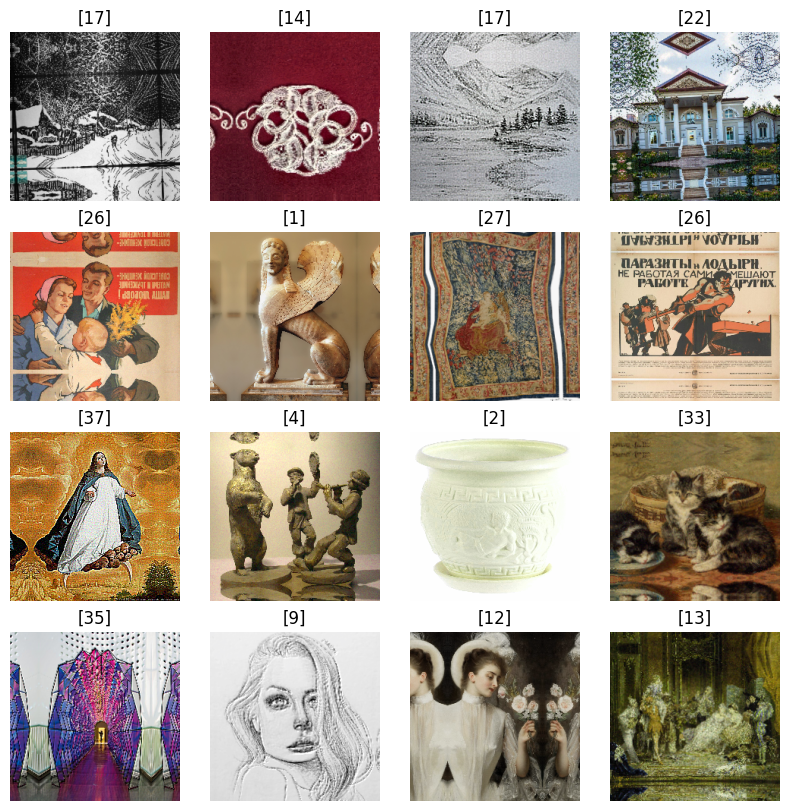

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharey=True, sharex=True, constrained_layout=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 10000))
    im_val, label = dataset[random_characters]
    imshow(im_val.data.cpu(), title=decode([label]), plt_ax=fig_x)
    fig_x.axis('off')

### Summary

The labeled data includes 15653 colored and grayscale images, classified into 40 classes. Label distribution is mostly uniform.

## Deep Dark Learning

### Data preparation

10% of the labeled data will be used for validation.

In [19]:
train_len = int(len(dataset)*0.9)
val_len = len(dataset) - train_len

print(f'Train set: {train_len} images, validation: {val_len} images.')
train_dataset, val_dataset = random_split(dataset, [train_len, val_len], generator=torch.Generator().manual_seed(RANDOM_STATE))

Train set: 14087 images, validation: 1566 images.


In [20]:
#train_dataset = dataset

In [21]:
# Optional class balancing.
'''
target_train = [item[1] for item in train_dataset]
class_count = Counter(target_train)
class_weights = torch.DoubleTensor([len(target_train) / c for c in pd.Series(class_count).sort_index().values])
sample_weights = [class_weights[idx] for idx in target_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_dataset)*2), replacement=True)
'''

'\ntarget_train = [item[1] for item in train_dataset]\nclass_count = Counter(target_train)\nclass_weights = torch.DoubleTensor([len(target_train) / c for c in pd.Series(class_count).sort_index().values])\nsample_weights = [class_weights[idx] for idx in target_train]\nsampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_dataset)*2), replacement=True)\n'

### Building models

In [22]:
# Monitoring F1@0.5 with different averaging methods:
epoch_scorers = list(map(lambda mode: EpochScoring(make_scorer(f1_score, average=mode, zero_division=0),
                                                name=f'f1_{mode}',
                                                lower_is_better=False,
                                                use_caching=True),
                    ['micro', 'macro', 'weighted']))

In [23]:
progress = ProgressBar()

In [24]:
def build_net(model, val_set=predefined_split(val_dataset), n_epochs=5, lr=1e-4, checkpoint_callback=None, criterion=nn.BCEWithLogitsLoss):
    net = NeuralNetClassifier(
                model,
                max_epochs = n_epochs,
                batch_size = BATCH_SIZE,
                lr = lr,
                criterion = criterion,
                optimizer = AdamW,
                optimizer__weight_decay = 5e-6,
                device = DEVICE,
                # Switch between the following two lines to enable/disable balancing: 
                # iterator_train__sampler = sampler,
                iterator_train__shuffle = True,
                iterator_train__num_workers = NUM_WORKERS,
                iterator_valid__num_workers = NUM_WORKERS,
                #iterator_train__pin_memory = True,
                #iterator_valid__pin_memory = True,
        
                train_split = val_set,
        
                callbacks = [progress,
                             checkpoint_callback,
                             *epoch_scorers,
                             LRScheduler(policy='CosineAnnealingLR', T_max=n_epochs, eta_min=1e-7),
                            ],
    )
    return net

We'll be trying out the following light classification models:
- swin visual transformer ([Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030))
- XCiT visual transfomer ([XCiT: Cross-Covariance Image Transformers
](https://arxiv.org/abs/2106.09681))
- Normalization-free network (ECA-NFNet) ([High-Performance Large-Scale Image Recognition Without Normalization](https://arxiv.org/abs/2102.06171))

In [25]:
model1 = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained=True, num_classes=CODE_SIZE)
model2 = timm.create_model('xcit_small_24_p16_224_dist', pretrained=True, num_classes=CODE_SIZE)
model3 = timm.create_model('eca_nfnet_l1', pretrained=True, num_classes=CODE_SIZE)

In [26]:
cp1 = Checkpoint(dirname='art-model1', load_best=True, monitor='valid_acc_best')
cp2 = Checkpoint(dirname='art-model2', load_best=True, monitor='valid_acc_best')
cp3 = Checkpoint(dirname='art-model3', load_best=True, monitor='valid_acc_best')

In [27]:
net1 = build_net(model1, checkpoint_callback=cp1)
net2 = build_net(model2, checkpoint_callback=cp2)
net3 = build_net(model3, checkpoint_callback=cp3)

In [28]:
class ErrorCorrection:
    def __init__(self, model, n_classes, code_book):
        self.model = model
        self.n_classes = n_classes
        self.code_book = code_book
        
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict_proba(self, X):
        p_hat = np.zeros((len(X), self.n_classes))
        indicator = self.code_book.astype(bool)
        r = np.array(self.model.predict_proba(X))[:,1]
        not_r = 1 - r
        for c in range(self.n_classes):
            class_indicator = indicator[c]
            p_hat[:, c] = r[:, class_indicator].sum(axis=1) + not_r[:, ~class_indicator].sum(axis=1)
        return p_hat / p_hat.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        predictions = self.model.predict(X)
        distances = [[cityblock(self.code_book[i], predictions[j]) for i in range(self.n_classes)] for j in range(len(predictions))]
        return decode(predictions)
    
    def test(self):
        X, y_raw = make_classification(n_samples=10000, n_features=20, n_informative=10, n_classes=self.n_classes)
        y = [self.code_book[c] for c in y_raw]
        X_train, y_train = X[:8000], y[:8000]
        X_test, y_test = X[8000:], y[8000:]
        self.model.fit(X_train, y_train)
        probs = self.predict_proba(X_test)
        preds = self.predict(X_test)
        return np.mean(probs.argmax(axis=1) == preds)

In [29]:
ecoc1 = ErrorCorrection(net1, NUM_CLASSES, dataset.code_book)
ecoc2 = ErrorCorrection(net2, NUM_CLASSES, dataset.code_book)
ecoc3 = ErrorCorrection(net3, NUM_CLASSES, dataset.code_book)

### Training

In [30]:
ecoc1.fit(train_dataset, None);

  0%|          | 0/979 [00:00<?, ?it/s]

  epoch    f1_macro    f1_micro    f1_weighted    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ----------  ----------  -------------  ------------  -----------  ------------  ----  ------  --------
      1      0.9262      0.9283         0.9282        0.2771       0.7452        0.1802     +  0.0001  475.7529


  0%|          | 0/979 [00:00<?, ?it/s]

      2      0.9253      0.9275         0.9275        0.1551       0.7720        0.1591     +  0.0001  481.3879


  0%|          | 0/979 [00:00<?, ?it/s]

      3      0.9204      0.9226         0.9226        0.1019       0.7880        0.1747     +  0.0001  484.6272


  0%|          | 0/979 [00:00<?, ?it/s]

      4      0.9519      0.9533         0.9533        0.0618       0.8710        0.1205     +  0.0000  486.2362


  0%|          | 0/979 [00:00<?, ?it/s]

      5      0.9555      0.9567         0.9567        0.0407       0.8787        0.1156     +  0.0000  486.4836


In [31]:
torch.cuda.empty_cache()

In [32]:
ecoc2.fit(train_dataset, None);

  0%|          | 0/979 [00:00<?, ?it/s]

  epoch    f1_macro    f1_micro    f1_weighted    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ----------  ----------  -------------  ------------  -----------  ------------  ----  ------  --------
      1      0.9002      0.9028         0.9029        0.3445       0.6788        0.2536     +  0.0001  420.9316


  0%|          | 0/979 [00:00<?, ?it/s]

      2      0.9274      0.9296         0.9295        0.1773       0.7490        0.1826     +  0.0001  421.4891


  0%|          | 0/979 [00:00<?, ?it/s]

      3      0.9348      0.9365         0.9365        0.1141       0.8142        0.1648     +  0.0001  421.3014


  0%|          | 0/979 [00:00<?, ?it/s]

      4      0.9418      0.9433         0.9433        0.0767       0.8276        0.1500     +  0.0000  422.7763


  0%|          | 0/979 [00:00<?, ?it/s]

      5      0.9521      0.9534         0.9534        0.0546       0.8582        0.1282     +  0.0000  421.7464


In [33]:
torch.cuda.empty_cache()

In [34]:
ecoc3.fit(train_dataset, None);

  0%|          | 0/979 [00:00<?, ?it/s]

  epoch    f1_macro    f1_micro    f1_weighted    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ----------  ----------  -------------  ------------  -----------  ------------  ----  ------  --------
      1      0.9155      0.9176         0.9176        0.2762       0.6743        0.1945     +  0.0001  296.9638


  0%|          | 0/979 [00:00<?, ?it/s]

      2      0.9330      0.9350         0.9350        0.1474       0.7656        0.1559     +  0.0001  294.3163


  0%|          | 0/979 [00:00<?, ?it/s]

      3      0.9417      0.9434         0.9434        0.0901       0.8238        0.1484     +  0.0001  294.1557


  0%|          | 0/979 [00:00<?, ?it/s]

      4      0.9471      0.9486         0.9486        0.0561       0.8499        0.1344     +  0.0000  294.3189


  0%|          | 0/979 [00:00<?, ?it/s]

      5      0.9484      0.9498         0.9498        0.0336       0.8621        0.1586     +  0.0000  294.1628


In [35]:
torch.cuda.empty_cache()

In [36]:
#net1.save_params(f_params='model1-art.pkl')
#net2.save_params(f_params='model2-art.pkl')
#net3.save_params(f_params='model3-art.pkl')

In [37]:
'''
net1.initialize()
net1.load_params(f_params='model1-art.pkl')
net2.initialize()
net2.load_params(f_params='model2-art.pkl')
net3.initialize()
net3.load_params(f_params='model3-art.pkl')
'''

"\nnet1.initialize()\nnet1.load_params(f_params='model1-art.pkl')\nnet2.initialize()\nnet2.load_params(f_params='model2-art.pkl')\nnet3.initialize()\nnet3.load_params(f_params='model3-art.pkl')\n"

In [38]:
model_list = [net1, net2, net3]

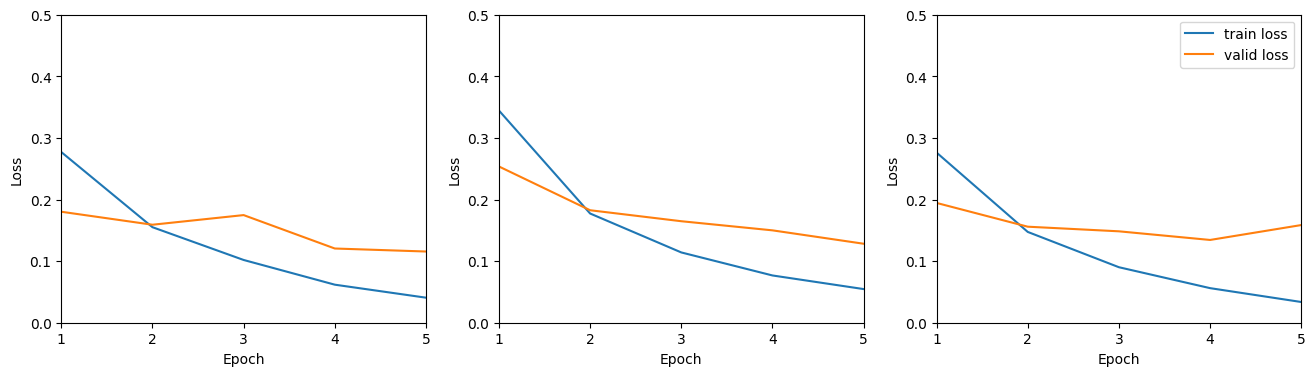

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, model in zip(axes.flat, model_list):
    l = len(model.history)
    ax.set(xticks = range(l), xticklabels = range(1, l+1), xlim=(0), ylim=(0, 0.5), xlabel='Epoch', ylabel='Loss')
    if model.history:
        ax.plot(model.history[:,['train_loss', 'valid_loss']]);
    plt.legend(['train loss', 'valid loss'])

## Validation

In [40]:
random_characters = int(np.random.uniform(0,1000))

In [41]:
def sanity_check(model, subset):
    fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey=True, sharex=True, constrained_layout=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        im_val, label = val_dataset[random_characters]
        prob_pred = model.predict_proba(im_val.unsqueeze(0))
        predicted_proba, y_pred = torch.max(torch.from_numpy(prob_pred), axis=1)
        text = f'Actual: {decode([label])}\nPredicted: {y_pred.item()}\nCertainty: {predicted_proba.item():.0%}'
    
        imshow(im_val.data.cpu(), title=text, plt_ax=fig_x)
        fig_x.axis('off')

In [42]:
indices=range(NUM_CLASSES)

In [43]:
def calculate_metrics(target_test, predictions, probabilities):
    acc = accuracy_score(target_test, predictions)
    cmatrix = confusion_matrix(target_test, predictions)

    ap, roc_auc, fpr, tpr, precision, recall, thresholds, f_scores, best_f, best_thresh = ([0 for i in range(NUM_CLASSES)] for j in range(10))

    target_vector = label_binarize(target_test, classes=indices)
    for i in indices:
        ap[i] = average_precision_score(target_vector[:, i], probabilities[:, i])
        fpr[i], tpr[i], _ = roc_curve(target_vector[:, i], probabilities[:, i])
        try:
            roc_auc[i] = roc_auc_score(target_vector[:, i], probabilities[:, i])
        except:
            roc_auc[i] = 0

        precision[i], recall[i], thresholds[i] = precision_recall_curve(target_vector[:, i], probabilities[:, i])
        # You may adjust the beta here:
        beta = 1
        f_scores[i] = (1 + beta ** 2) * recall[i] * precision[i] / (recall[i] + beta ** 2 * precision[i])
        best_thresh[i] = thresholds[i][np.argmax(f_scores[i])]
        best_f[i] = np.max(f_scores[i])

    return best_f, roc_auc, acc, ap, best_thresh, beta, fpr, tpr, recall, precision, cmatrix

In [44]:
def visualize(target_test, probabilities):
    predictions = probabilities.argmax(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    best_f, roc_auc, acc, ap, best_thresh, beta, fpr, tpr, recall, precision, cmatrix = calculate_metrics(target_test, predictions, probabilities)
    for i in indices:
        axes[0].plot (fpr[i], tpr[i], label=f' {nice_label(i)} - ROC_AUC: {roc_auc[i]:.2f}, AP (PR_AUC): {ap[i]:.2f}, best {r"$F_{"+str(beta)+r"}$"}: {best_f[i]:.2f} @ {best_thresh[i]:.2f} threshold');
        axes[1].plot (recall[i], precision[i]);
    axes[0].legend(bbox_to_anchor=(1.8, -2.5), loc='lower right')

    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC curves', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR curves', xlim=(0,1), ylim=(0,1))
    plt.show()
    fig, axes = plt.subplots(1, 1, figsize=(15,10))
    labs = [nice_label(i) for i in indices]
    sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='d').set(title='Confusion matrix', xlabel='Predicted', ylabel='Actual',
        xticks=np.arange(0.5, len(labs)+0.5, 1.0), yticks=np.arange(0.5, len(labs)+0.5, 1.0), xticklabels=labs, yticklabels=labs)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    unpacked_thresholds = [best_thresh[i] for i in indices]

    return unpacked_thresholds

In [45]:
def report(probabilities):
    predictions = probabilities.argmax(axis=1)
    idxs = [indices[i] for i in set(predictions)]
    print(classification_report(val_target, predictions, target_names=list(map(nice_label, idxs)), labels=idxs, zero_division=0))

In [46]:
val_target = decode([item[1] for item in val_dataset])

### Swin

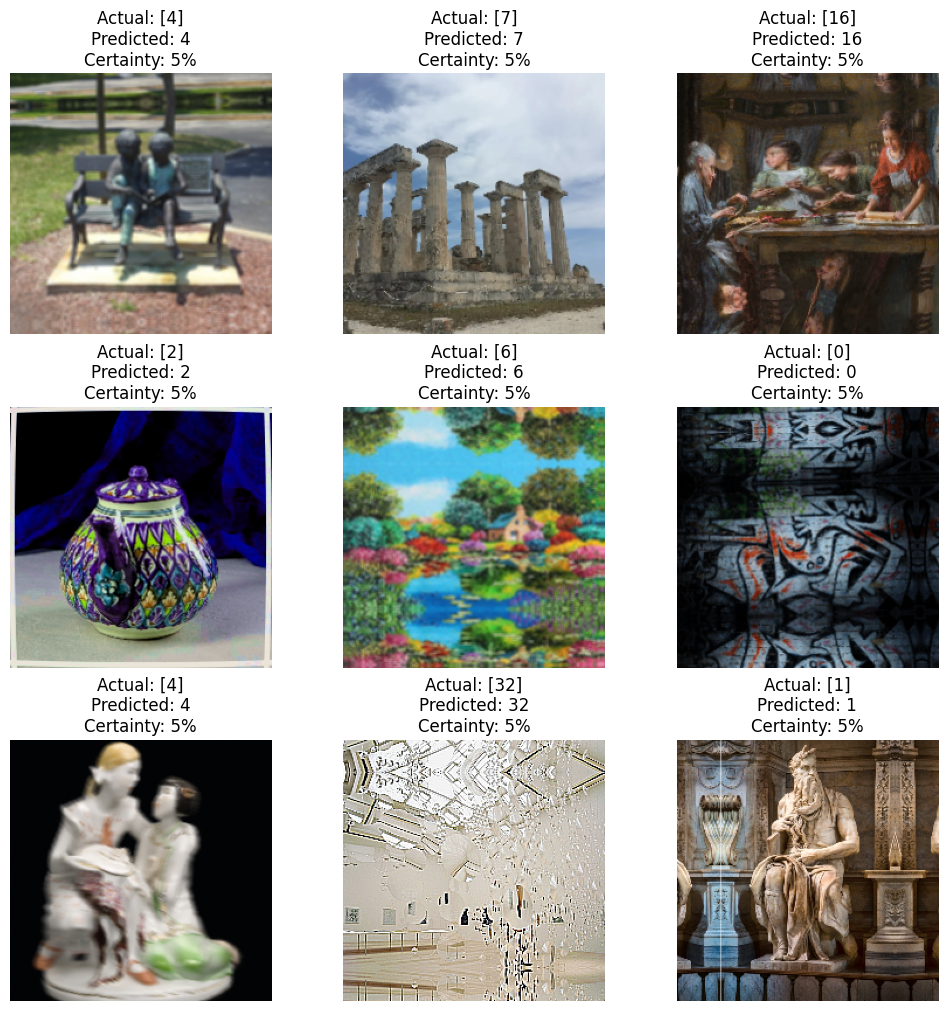

In [47]:
sanity_check(ecoc1, random_characters)

In [48]:
probabilities1 = ecoc1.predict_proba(val_dataset)

In [49]:
report(probabilities1)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.89      0.93      0.91        45
           2       0.98      0.98      0.98        41
           3       0.95      0.88      0.92        43
           4       0.88      0.93      0.90        40
           5       0.96      0.90      0.93        29
           6       1.00      0.96      0.98        47
           7       0.92      0.94      0.93        36
           8       1.00      1.00      1.00        35
           9       1.00      1.00      1.00        31
          10       0.93      0.85      0.89        46
          11       0.94      0.98      0.96        48
          12       0.97      1.00      0.98        32
          13       0.88      0.91      0.89        46
          14       1.00      1.00      1.00        44
          15       1.00      1.00      1.00        38
          16       0.92      0.92      0.92        49
          17       0.98    

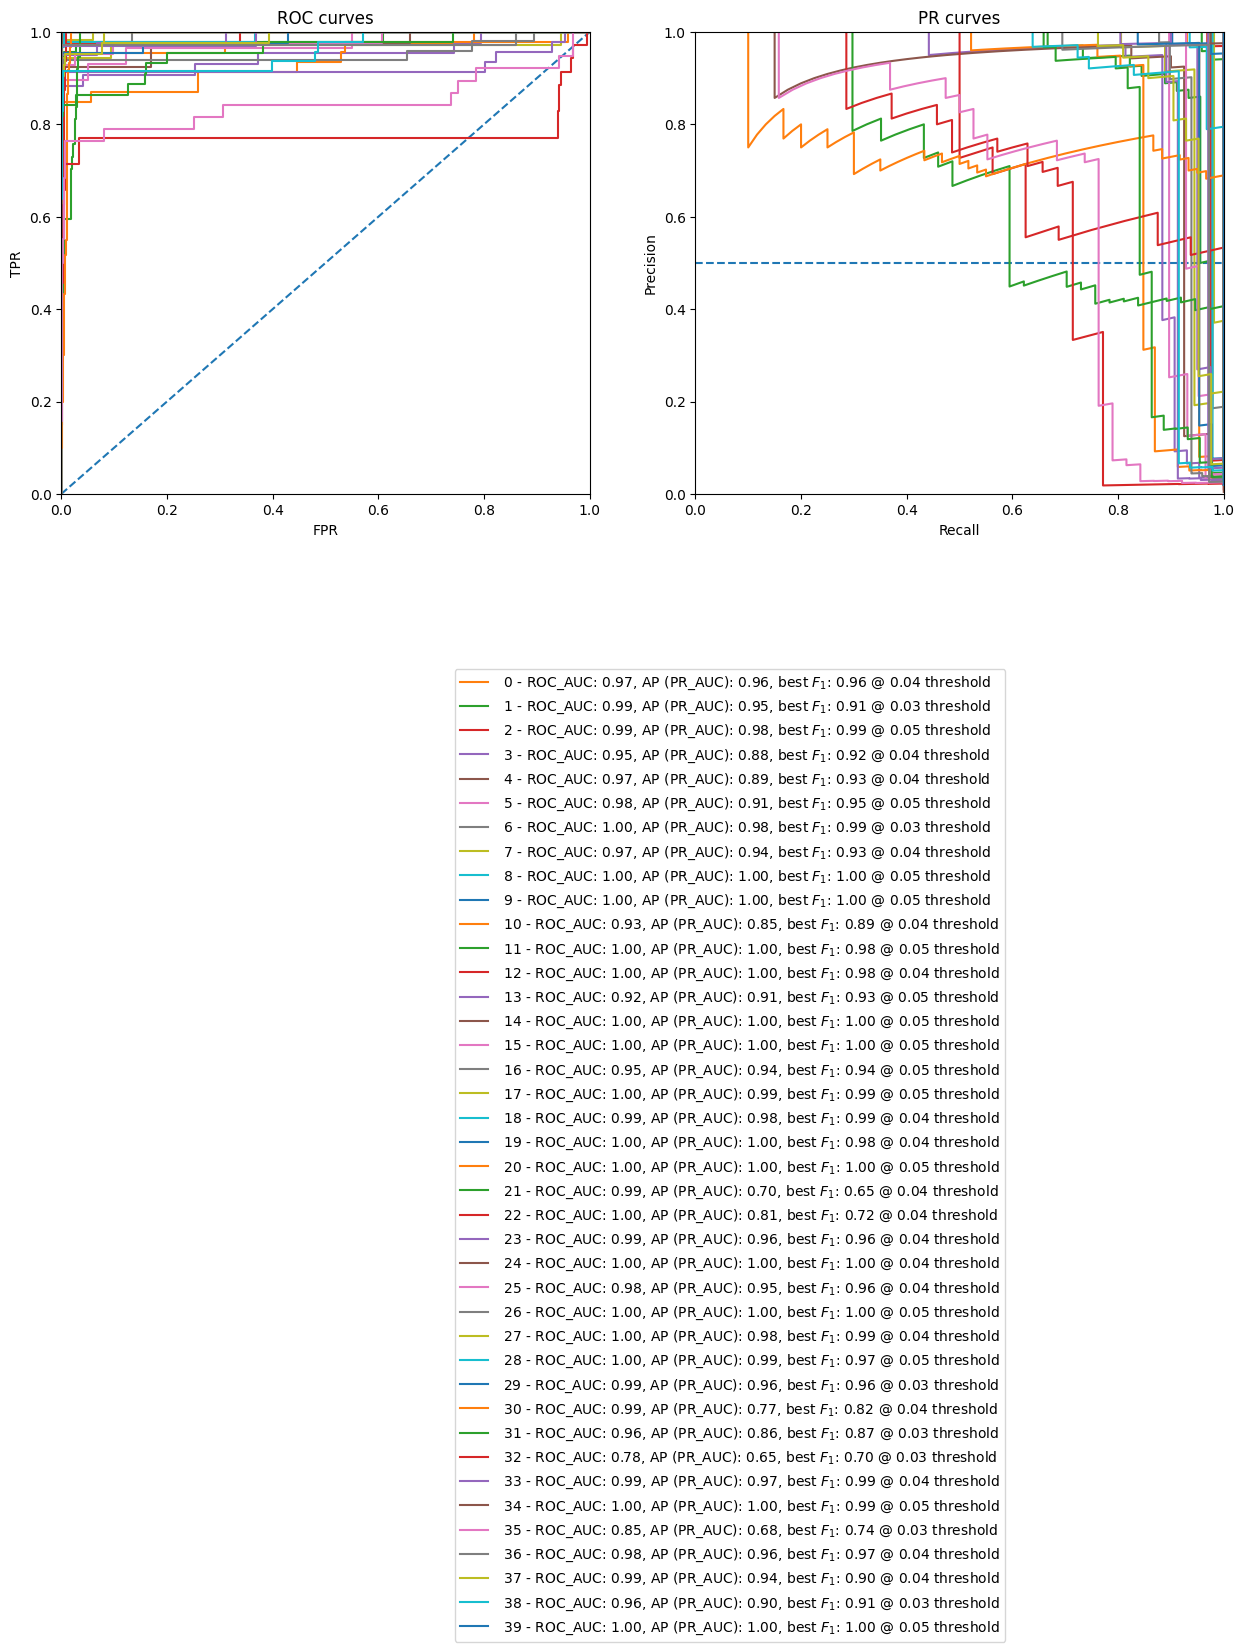

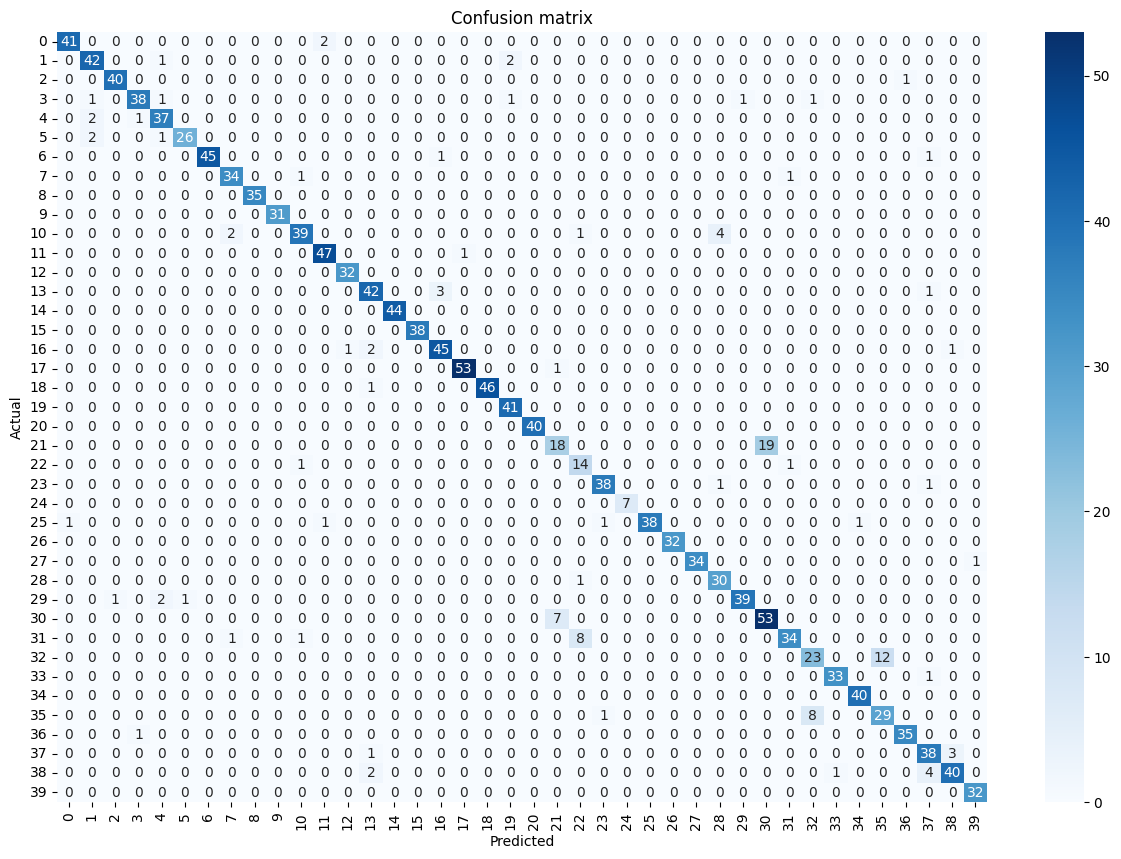

In [50]:
best_thresholds1 = visualize(val_target, probabilities1)

### XcIT

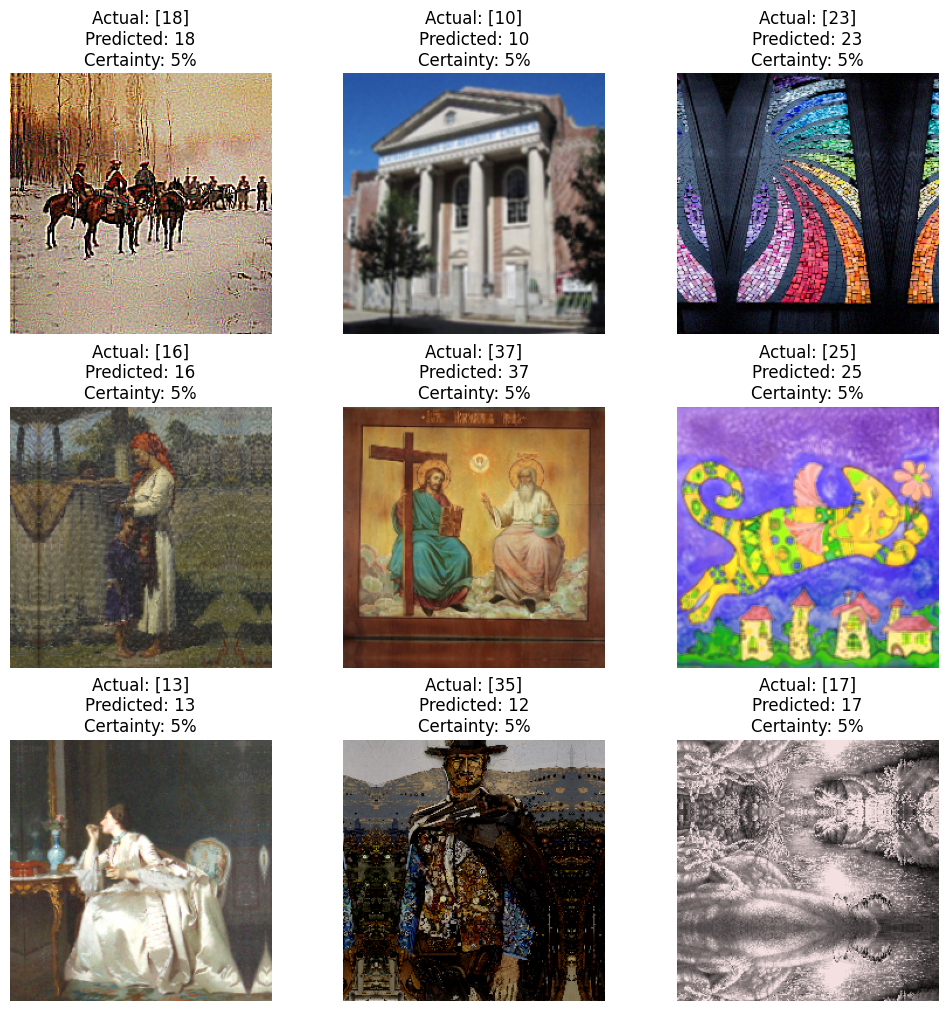

In [51]:
sanity_check(ecoc2, random_characters)

In [52]:
probabilities2 = ecoc2.predict_proba(val_dataset)

In [53]:
report(probabilities2)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.84      0.93      0.88        45
           2       1.00      0.98      0.99        41
           3       0.92      0.84      0.88        43
           4       0.85      0.82      0.84        40
           5       1.00      0.93      0.96        29
           6       0.98      1.00      0.99        47
           7       0.85      0.94      0.89        36
           8       1.00      1.00      1.00        35
           9       0.97      1.00      0.98        31
          10       0.88      0.78      0.83        46
          11       0.96      0.96      0.96        48
          12       0.94      1.00      0.97        32
          13       0.89      0.91      0.90        46
          14       1.00      1.00      1.00        44
          15       0.97      1.00      0.99        38
          16       0.96      0.92      0.94        49
          17       0.96    

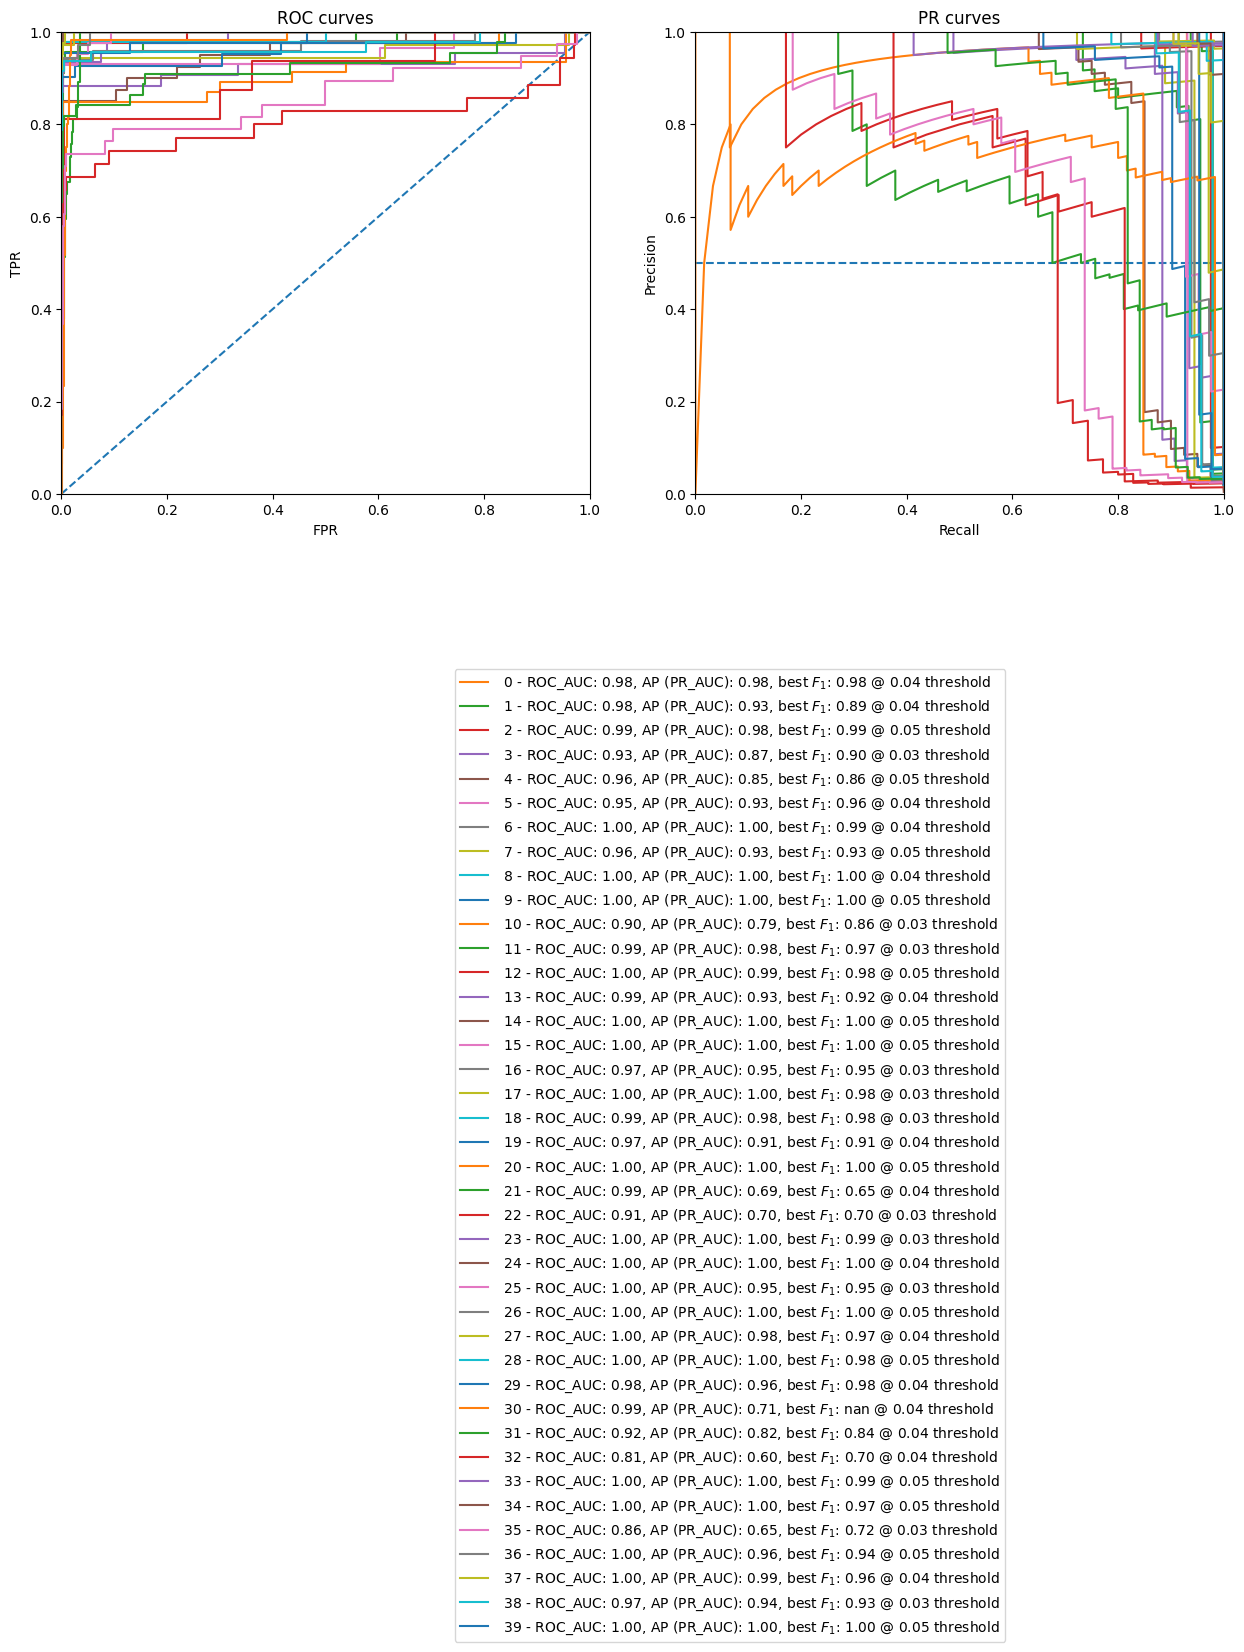

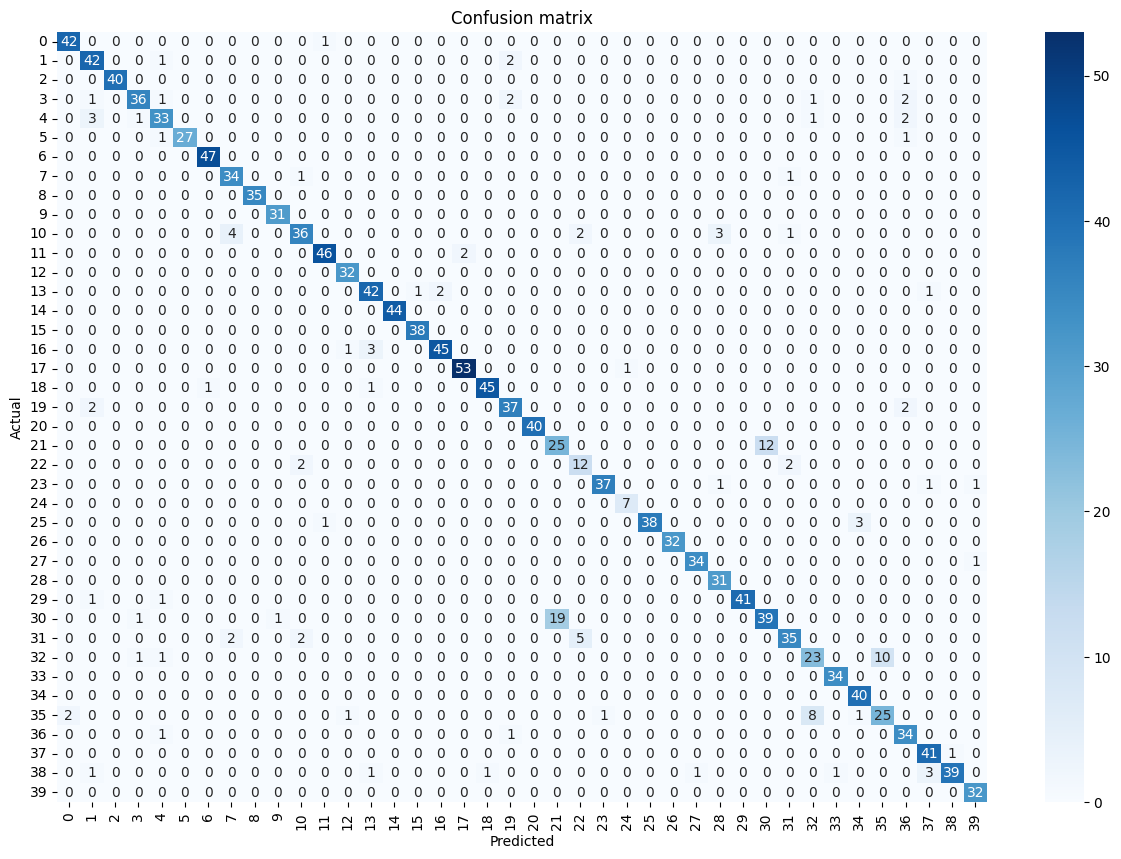

In [54]:
best_thresholds2 = visualize(val_target, probabilities2)

### ECA-NFNet

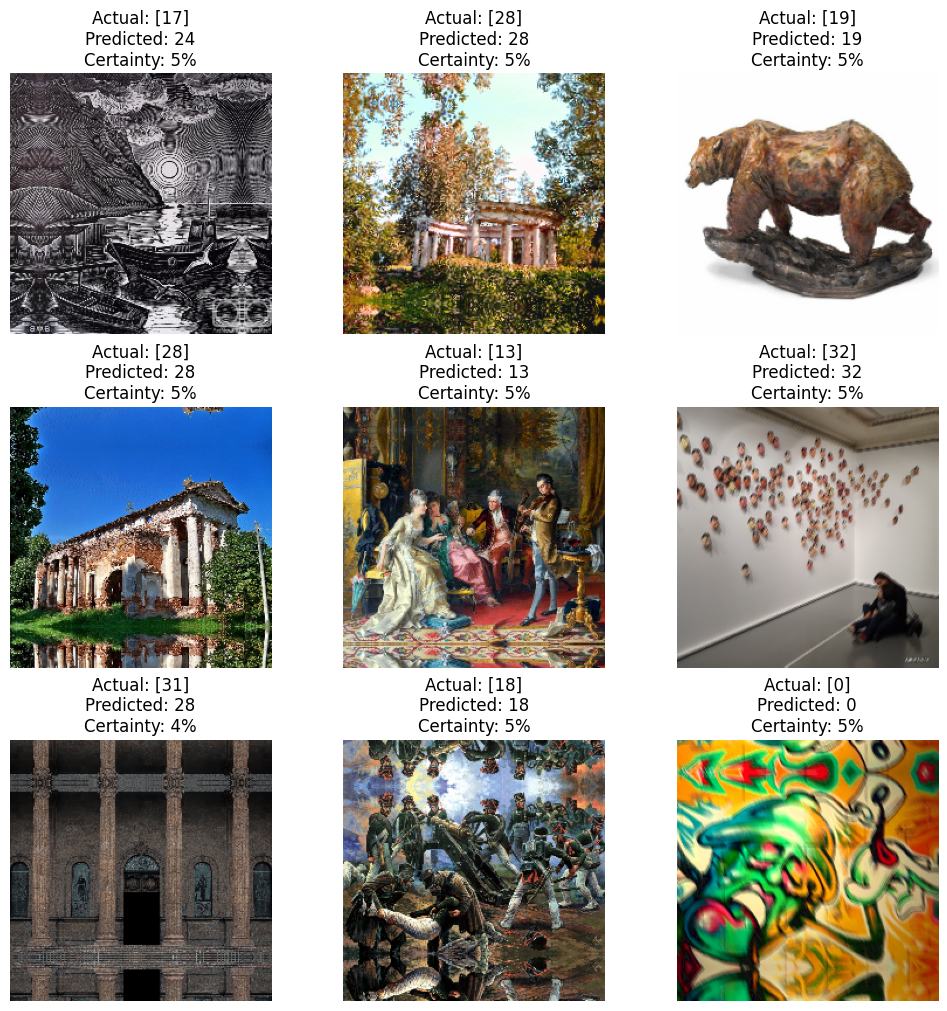

In [55]:
sanity_check(ecoc3, random_characters)

In [56]:
probabilities3 = ecoc3.predict_proba(val_dataset)

In [57]:
report(probabilities3)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.83      0.89      0.86        45
           2       0.97      0.95      0.96        41
           3       0.88      0.88      0.88        43
           4       0.84      0.90      0.87        40
           5       0.96      0.90      0.93        29
           6       0.98      0.98      0.98        47
           7       0.89      0.94      0.92        36
           8       1.00      0.97      0.99        35
           9       0.94      1.00      0.97        31
          10       0.88      0.91      0.89        46
          11       0.94      0.98      0.96        48
          12       0.94      0.94      0.94        32
          13       0.91      0.87      0.89        46
          14       1.00      1.00      1.00        44
          15       0.97      0.97      0.97        38
          16       0.94      0.96      0.95        49
          17       1.00    

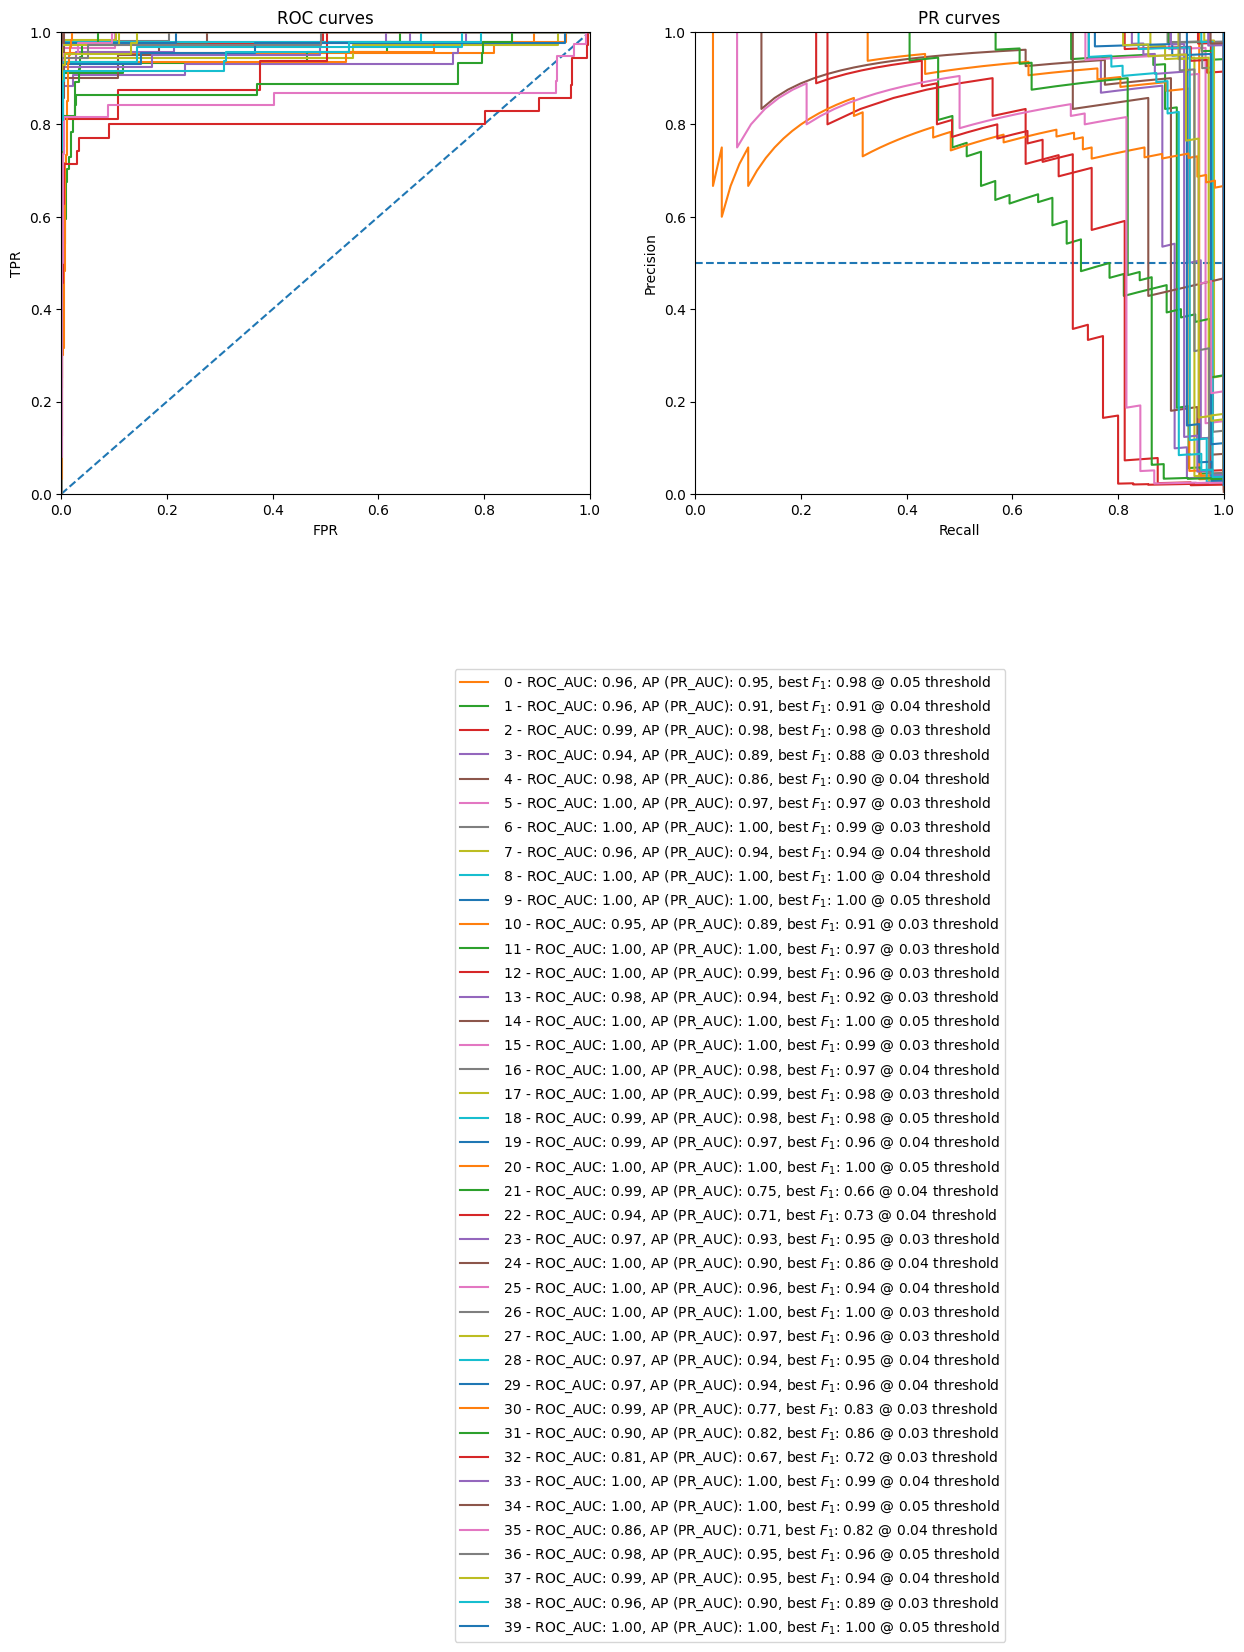

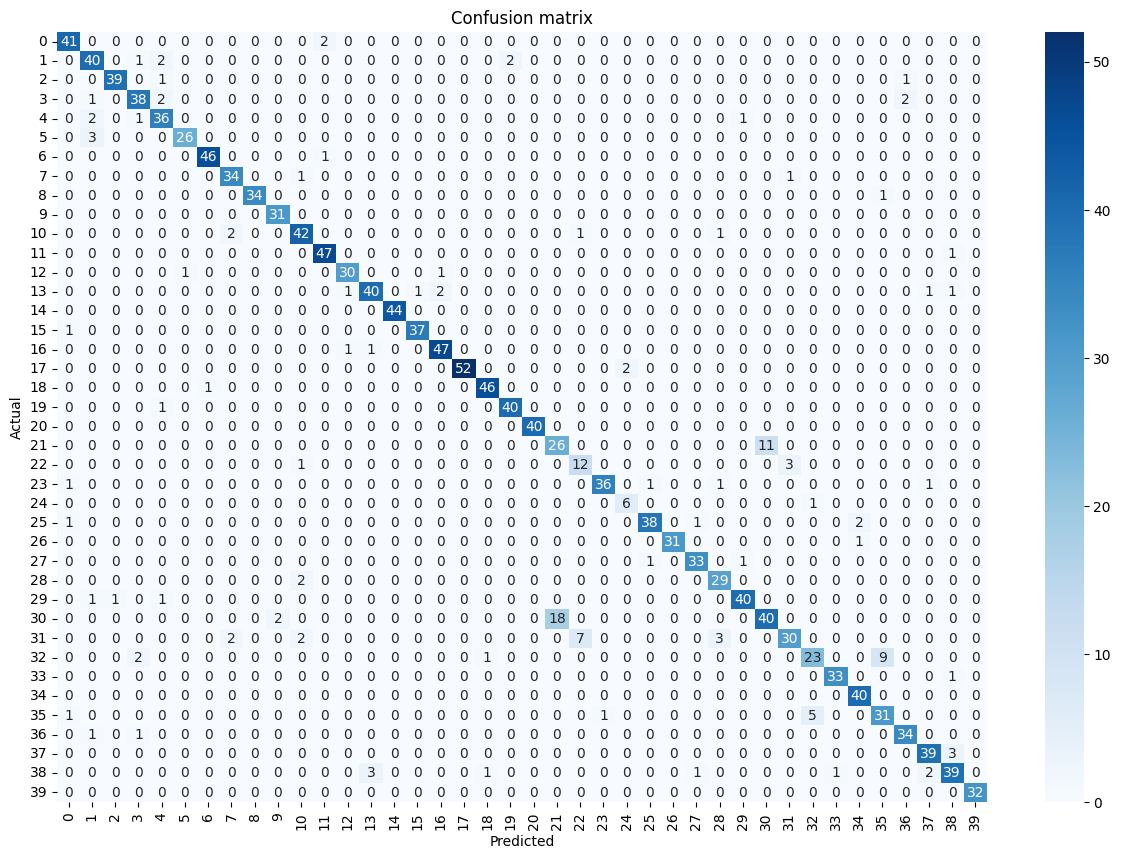

In [58]:
best_thresholds3 = visualize(val_target, probabilities3)

### Summary

The result is acceptable, however the following classes need better separation:

- 21 vs 30
- 32 vs 35
- to a lesser extent, 22 vs 31 and 37 vs 38.

## Ensembling

Models' scores are bleded together using soft voting or stacking.

In [59]:
def vote(X):
    probs1 = ecoc1.predict_proba(X)
    probs2 = ecoc2.predict_proba(X)
    probs3 = ecoc3.predict_proba(X)
    return np.stack((probs1, probs2, probs3)).mean(axis=0)

In [60]:
probabilities_vote = vote(val_dataset)

In [61]:
report(probabilities_vote)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.85      0.89      0.87        45
           2       0.98      0.98      0.98        41
           3       0.91      0.91      0.91        43
           4       0.90      0.93      0.91        40
           5       1.00      0.86      0.93        29
           6       0.98      1.00      0.99        47
           7       0.92      0.94      0.93        36
           8       1.00      1.00      1.00        35
           9       0.94      1.00      0.97        31
          10       0.91      0.85      0.88        46
          11       0.96      0.98      0.97        48
          12       0.94      1.00      0.97        32
          13       0.91      0.91      0.91        46
          14       1.00      1.00      1.00        44
          15       0.97      1.00      0.99        38
          16       0.98      0.98      0.98        49
          17       0.98    

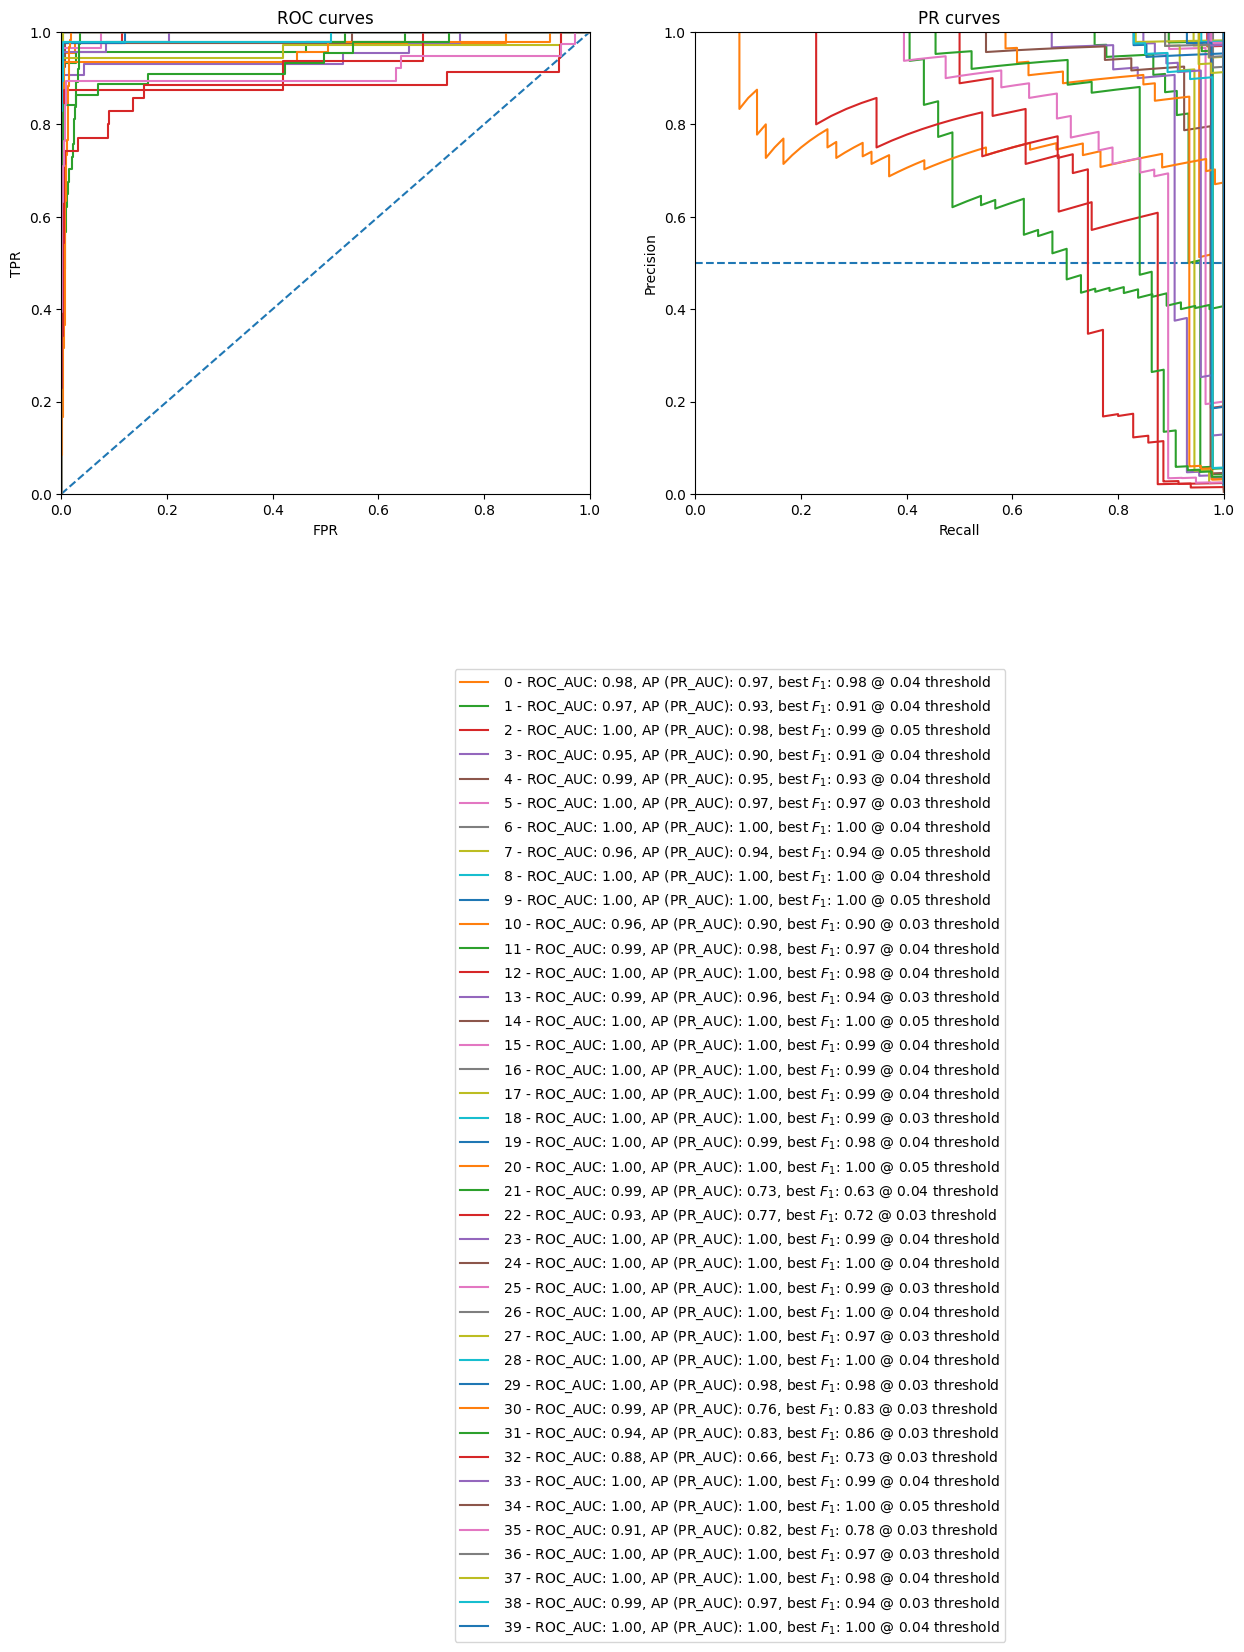

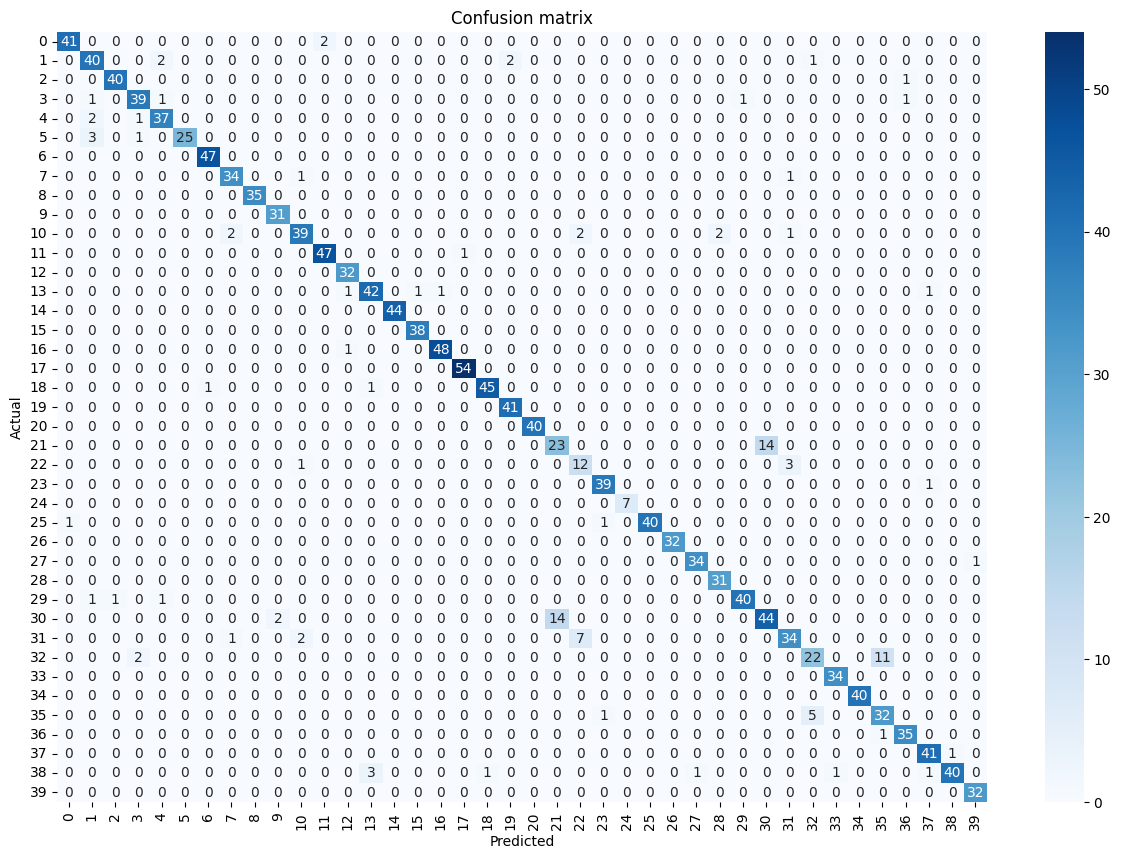

In [62]:
best_thresholds = visualize(val_target, probabilities_vote)

## Submission

In [63]:
test_dataset = ArtDataset(TEST_DIR, labels)

In [64]:
probs = vote(test_dataset)

In [65]:
# Experimental: try best thresholds when possible:
tags = probs > best_thresholds
predictions = [tags[i].argmax() if tags[i].sum() == 1 else probs[i].argmax() for i in range(len(test_dataset))]
print(f'Differences with straight argmax: {(probs.argmax(axis=1) != predictions).sum()}')

Differences with straight argmax: 38


In [66]:
# Straight argmax:
predictions = probs.argmax(axis=1)

In [67]:
test_filenames = test_dataset.files
my_submit = pd.DataFrame({'image_name': test_filenames, 'label_id': predictions})
my_submit.head()

image_name  label_id
0  7b6faf8476e847feb7afd2a7ba1e6401.jpg         0
1  ebe4f29df3bd44adbda3354372368456.jpg         0
2  9291a322bbc64d57a5afbe5de45b0d68.jpg         0
3  ad3cb44b38254b639f2e48feefa35f3c.jpg        25
4  1949621ad1d34f9fb645ec0a17877d08.jpg         0

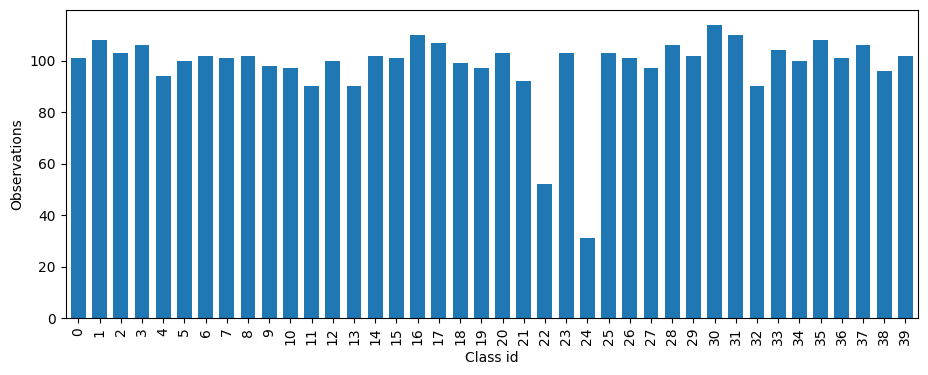

In [68]:
# Answers' distribution:
my_submit['label_id'].value_counts().sort_index().plot(kind='bar', figsize=(11,4), width=0.7).set(xlabel='Class id', ylabel='Predictions');

In [69]:
my_submit.to_csv('submission.csv', index=False, sep='\t')

## Conclusion

The baseline score of a single model was about 92.4% F1 (macro averaged). Ensembling and more augmentations yielded less than 0.5% improvement.

ECOC approach instantly scores above 93% with a single model. Ensembling and fine tuning further increase the score to nearly 94% without any probing of the public test set.

A potential improvement would be using specialized siamese networks for distinguishing between problematic class pairs. Sadly, time constrainsts did not allow to implement this in time.